# Deep Reinforcement Learning for Portfolio Optimization

**IEDA4000F - Deep Learning for Decision Analytics**  
**The Hong Kong University of Science and Technology (HKUST)**

---

This notebook demonstrates the complete pipeline for training and evaluating DRL agents for portfolio optimization.

## Table of Contents
1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Environment Creation](#2-environment-creation)
3. [Training DRL Agents](#3-training-drl-agents)
4. [Running Benchmarks](#4-running-benchmarks)
5. [Performance Evaluation](#5-performance-evaluation)
6. [Visualization and Analysis](#6-visualization-and-analysis)
7. [Conclusions](#7-conclusions)

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

from src.data_loader import DataLoader
from src.portfolio_env import PortfolioEnv
from src.agents import create_agent, train_agent
from src.benchmarks import run_all_benchmarks
from src.metrics import PerformanceMetrics, compare_strategies
from src.visualization import *

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


### 1.1 Define Asset Universe and Parameters

In [2]:
# Define assets for portfolio
ASSETS = ['AAPL', 'NVDA', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'SPY', 'GLD']

# Date range
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'

# Training parameters
TRAIN_RATIO = 0.7
TRANSACTION_COST = 0.001  # 0.1%
INITIAL_BALANCE = 100000.0

print(f"Asset Universe: {ASSETS}")
print(f"Number of Assets: {len(ASSETS)}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Transaction Cost: {TRANSACTION_COST*100}%")

Asset Universe: ['AAPL', 'NVDA', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'SPY', 'GLD']
Number of Assets: 8
Date Range: 2015-01-01 to 2024-12-31
Transaction Cost: 0.1%


### 1.2 Download and Process Data

In [3]:
# Initialize data loader
loader = DataLoader(
    assets=ASSETS,
    start_date=START_DATE,
    end_date=END_DATE,
    data_dir='../data'
)

# Download data
print("Downloading data from Yahoo Finance...")
prices = loader.download_data()

print(f"\nData shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print(f"\nFirst few rows:")
prices.head()

[*********************100%***********************]  8 of 8 completed

Data saved to ../data/prices_AAPL_NVDA_TSLA_MSFT_GOOGL_AMZN_SPY_GLD_2015-01-01_2024-12-31.csv
Downloaded 2515 periods for 8 assets

Data shape: (2515, 8)
Date range: 2015-01-02 00:00:00 to 2024-12-30 00:00:00

First few rows:


Ticker,AAPL,AMZN,GLD,GOOGL,MSFT,NVDA,SPY,TSLA
Date,,,,,,,,
2015-01-02,24.237549,15.4260,114.080002,26.296133,39.858456,0.483038,171.093689,14.620667
2015-01-05,23.554747,15.1095,115.800003,25.795088,39.491920,0.474880,168.003830,14.006000
2015-01-06,23.556953,14.7645,117.120003,25.158482,38.912289,0.460482,166.421402,14.085333
2015-01-07,23.887281,14.9210,116.430000,25.084488,39.406685,0.459282,168.495178,14.063333
2015-01-08,24.805082,15.0230,115.940002,25.171888,40.565945,0.476559,171.485123,14.041333


In [4]:
# Compute returns
returns, log_returns = loader.compute_returns()

print(f"Returns shape: {returns.shape}")
print(f"\nBasic statistics:")
print(returns.describe())

Returns shape: (2514, 8)

Basic statistics:
Ticker         AAPL         AMZN          GLD        GOOGL         MSFT  \
count   2514.000000  2514.000000  2514.000000  2514.000000  2514.000000   
mean       0.001091     0.001272     0.000337     0.000949     0.001085   
std        0.017932     0.020653     0.008896     0.017937     0.017098   
min       -0.128647    -0.140494    -0.053694    -0.116341    -0.147391   
25%       -0.007328    -0.008634    -0.004645    -0.007515    -0.006728   
50%        0.001001     0.001153     0.000497     0.001240     0.000958   
75%        0.010143     0.011308     0.005086     0.009548     0.009779   
max        0.119808     0.141311     0.049038     0.162584     0.142169   

Ticker         NVDA          SPY         TSLA  
count   2514.000000  2514.000000  2514.000000  
mean       0.002714     0.000550     0.001979  
std        0.030621     0.011101     0.036009  
min       -0.187558    -0.109424    -0.210628  
25%       -0.012436    -0.003705    -0.0

### 1.3 Feature Engineering

In [5]:
# Build features with technical indicators
print("Building features with technical indicators...")
features = loader.build_features(
    sma_periods=[5, 10, 20],
    ema_periods=[5, 10, 20],
    momentum_periods=[5, 10, 20],
    include_volatility=True,
    normalize=True,
    normalize_method='zscore',
    rolling_window=60
)

print(f"\nFeature set shape: {features.shape}")
print(f"Number of features: {features.shape[1]}")
print(f"\nFeature columns (first 10):")
print(features.columns[:10].tolist())

Building features with technical indicators...
Building feature set...
Built 96 features over 2494 periods

Feature set shape: (2494, 96)
Number of features: 96

Feature columns (first 10):
['AAPL_PRICE_NORM', 'AMZN_PRICE_NORM', 'GLD_PRICE_NORM', 'GOOGL_PRICE_NORM', 'MSFT_PRICE_NORM', 'NVDA_PRICE_NORM', 'SPY_PRICE_NORM', 'TSLA_PRICE_NORM', 'AAPL_RETURN', 'AMZN_RETURN']


### 1.4 Train-Test Split

In [6]:
# Split data into training and testing sets
train_data, test_data = loader.train_test_split(train_ratio=TRAIN_RATIO)

print("Data split summary:")
print(f"Train period: {train_data['prices'].index[0]} to {train_data['prices'].index[-1]}")
print(f"Train samples: {len(train_data['prices'])}")
print(f"\nTest period: {test_data['prices'].index[0]} to {test_data['prices'].index[-1]}")
print(f"Test samples: {len(test_data['prices'])}")

Train period: 2015-02-03 00:00:00 to 2022-01-05 00:00:00
Test period: 2022-01-06 00:00:00 to 2024-12-30 00:00:00
Train samples: 1745
Test samples: 749
Data split summary:
Train period: 2015-02-03 00:00:00 to 2022-01-05 00:00:00
Train samples: 1745

Test period: 2022-01-06 00:00:00 to 2024-12-30 00:00:00
Test samples: 749


### 1.5 Asset Statistics

In [7]:
# Get asset statistics
stats = loader.get_asset_statistics()

print("Asset Statistics:")
print(stats.round(4))

Asset Statistics:
       Mean Daily Return  Std Daily Return  Annualized Return  \
AAPL              0.0011            0.0179             0.3163   
NVDA              0.0027            0.0306             0.9798   
TSLA              0.0020            0.0360             0.6460   
MSFT              0.0011            0.0171             0.3142   
GOOGL             0.0009            0.0179             0.2699   
AMZN              0.0013            0.0207             0.3776   
SPY               0.0005            0.0111             0.1485   
GLD               0.0003            0.0089             0.0885   

       Annualized Volatility  Sharpe Ratio  Skewness  Kurtosis  Min Return  \
AAPL                  0.2847        0.9659   -0.0036    5.2984     -0.1286   
NVDA                  0.4861        1.4069    0.6257    8.3009     -0.1876   
TSLA                  0.5716        0.8726    0.2744    4.3854     -0.2106   
MSFT                  0.2714        1.0072    0.0746    7.7898     -0.1474   
GOOGL 

## 2. Environment Creation

In [8]:
# Create training environment
train_env = PortfolioEnv(
    prices=train_data['prices'],
    returns=train_data['returns'],
    features=train_data['features'],
    initial_balance=INITIAL_BALANCE,
    transaction_cost=TRANSACTION_COST,
    lookback_window=20,
    reward_type='risk_adjusted',
    risk_penalty_lambda=0.5,
    allow_short=False,
)

print("Training Environment:")
print(f"  Number of assets: {train_env.n_assets}")
print(f"  Max steps: {train_env.max_steps}")
print(f"  Observation space: {train_env.observation_space.shape}")
print(f"  Action space: {train_env.action_space.shape}")
print(f"  Transaction cost: {train_env.transaction_cost*100}%")

Training Environment:
  Number of assets: 8
  Max steps: 1724
  Observation space: (267,)
  Action space: (8,)
  Transaction cost: 0.1%


In [9]:
# Test environment with random actions
print("Testing environment with random actions...")
obs, info = train_env.reset()
print(f"Initial observation shape: {obs.shape}")
print(f"Initial portfolio value: ${info['portfolio_value']:,.2f}")

# Take a few random steps
for i in range(5):
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.step(action)
    print(f"Step {i+1}: Reward={reward:.4f}, Value=${info['portfolio_value']:,.2f}, Turnover={info['turnover']:.4f}")

Testing environment with random actions...
Initial observation shape: (267,)
Initial portfolio value: $100,000.00
Step 1: Reward=-83.7503, Value=$100,024.72, Turnover=1.4617
Step 2: Reward=-176.1430, Value=$98,391.44, Turnover=1.9732
Step 3: Reward=-48.1308, Value=$98,483.34, Turnover=1.0952
Step 4: Reward=-28.1032, Value=$98,466.12, Turnover=0.8758
Step 5: Reward=-112.2554, Value=$97,854.01, Turnover=1.5660


## 3. Training DRL Agents

We'll train PPO (Proximal Policy Optimization) agent, which is well-suited for continuous action spaces.

In [10]:
# Create PPO agent
print("Creating PPO agent...")
ppo_agent = create_agent(
    agent_type='ppo',
    env=train_env,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    net_arch=[128, 128],
    verbose=1
)

print("✓ PPO agent created successfully!")

Creating PPO agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✓ PPO agent created successfully!
✓ PPO agent created successfully!


In [11]:
# Train PPO agent
# Note: Use fewer timesteps for quick demo. Increase for better performance.
TRAIN_TIMESTEPS = 50000  # Increase to 100000+ for production

print(f"Training PPO agent for {TRAIN_TIMESTEPS} timesteps...")
print("This may take several minutes...\n")

ppo_agent.learn(total_timesteps=TRAIN_TIMESTEPS, log_interval=10)

print("\n✓ Training completed!")

Training PPO agent for 50000 timesteps...
This may take several minutes...

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.72e+03     |
|    ep_rew_mean          | 8.91e+05     |
| time/                   |              |
|    fps                  | 1037         |
|    iterations           | 10           |
|    time_elapsed         | 19           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0016997047 |
|    clip_fraction        | 0.00786      |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.4        |
|    explained_variance   | 0.006        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.82e+08     |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00041     |
|    std                  | 1            |
|    value_loss           | 4.45e+08     |
---------------------

In [12]:
# Save trained model
os.makedirs('../models', exist_ok=True)
model_path = '../models/ppo_demo.zip'
ppo_agent.save(model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../models/ppo_demo.zip


## 4. Running Benchmarks

In [13]:
# Run benchmark strategies on test data
print("Running benchmark strategies on test data...")

benchmark_results = run_all_benchmarks(
    returns=test_data['returns'],
    transaction_cost=TRANSACTION_COST,
    initial_value=INITIAL_BALANCE,
    mv_lookback=60,
    momentum_lookback=20,
    momentum_top_k=3,
)

print("\n✓ Benchmark strategies completed!")
print(f"\nBenchmarks run: {list(benchmark_results.keys())}")

Running benchmark strategies on test data...
Running Equal-Weight benchmark...
Running Mean-Variance benchmark...
Running Momentum benchmark...
Running Buy-and-Hold benchmark...

✓ Benchmark strategies completed!

Benchmarks run: ['Equal-Weight', 'Mean-Variance', 'Momentum', 'Buy-and-Hold']


## 5. Performance Evaluation

### 5.1 Evaluate PPO Agent on Test Set

In [14]:
# Create test environment
test_env = PortfolioEnv(
    prices=test_data['prices'],
    returns=test_data['returns'],
    features=test_data['features'],
    initial_balance=INITIAL_BALANCE,
    transaction_cost=TRANSACTION_COST,
    lookback_window=20,
    reward_type='risk_adjusted',
    risk_penalty_lambda=0.5,
    allow_short=False,
)

# Evaluate PPO agent
print("Evaluating PPO agent on test set...")
obs, info = test_env.reset()
done = False

while not done:
    action, _ = ppo_agent.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

# Get PPO results
ppo_history = test_env.get_portfolio_history()
ppo_results = {
    'returns': ppo_history['returns'],
    'values': ppo_history['values'],
    'weights': ppo_history['weights'],
    'turnover': ppo_history['turnover'],
}

print(f"✓ PPO evaluation completed!")
print(f"Final portfolio value: ${ppo_results['values'][-1]:,.2f}")
print(f"Total return: {(ppo_results['values'][-1]/INITIAL_BALANCE - 1)*100:.2f}%")

Evaluating PPO agent on test set...
✓ PPO evaluation completed!
Final portfolio value: $178,203.91
Total return: 78.20%
✓ PPO evaluation completed!
Final portfolio value: $178,203.91
Total return: 78.20%


### 5.2 Compare All Strategies

In [15]:
# Combine all results
all_results = {'PPO': ppo_results, **benchmark_results}

# Calculate metrics
metrics_df = compare_strategies(
    all_results,
    risk_free_rate=0.02,
    periods_per_year=252
)

print("\n" + "="*80)
print("Performance Metrics Comparison")
print("="*80)
print(metrics_df.to_string())
print("="*80)


Performance Metrics Comparison
               Total Return  Annualized Return  Annualized Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown  Calmar Ratio  VaR (95%)  CVaR (95%)  Hit Ratio  Skewness  Kurtosis  Average Turnover
PPO                0.782039           0.221395               0.199790      1.008033       1.872110      0.281900      0.785365   0.021543    0.027996   0.542582 -0.168074  0.722998          0.026453
Equal-Weight       0.772100           0.212282               0.260022      0.739484       1.373719      0.378354      0.561067   0.027843    0.036277   0.540721 -0.089308  1.192247          0.000000
Mean-Variance      0.772100           0.212282               0.260022      0.739484       1.373719      0.378354      0.561067   0.027843    0.036277   0.540721 -0.089308  1.192247          0.000000
Buy-and-Hold       0.772100           0.212282               0.260022      0.739484       1.373719      0.378354      0.561067   0.027843    0.036277   0.540721 -0.089308  

### 5.3 Detailed Metrics for Each Strategy

In [16]:
# Print detailed metrics
for name, data in all_results.items():
    metrics = PerformanceMetrics(
        returns=data['returns'],
        values=data['values'],
        weights=data.get('weights'),
        turnover=data.get('turnover'),
        risk_free_rate=0.02,
        periods_per_year=252
    )
    metrics.print_metrics(name)


 Performance Metrics: PPO
Total Return............................       78.20%
Annualized Return.......................       22.14%
Annualized Volatility...................       19.98%
Sharpe Ratio............................       1.0080
Sortino Ratio...........................       1.8721
Max Drawdown............................       28.19%
Calmar Ratio............................       0.7854
VaR (95%)...............................        2.15%
CVaR (95%)..............................        2.80%
Hit Ratio...............................       0.5426
Skewness................................      -0.1681
Kurtosis................................       0.7230
Average Turnover........................        2.65%


 Performance Metrics: Equal-Weight
Total Return............................       77.21%
Annualized Return.......................       21.23%
Annualized Volatility...................       26.00%
Sharpe Ratio............................       0.7395
Sortino Ratio.....

## 6. Visualization and Analysis

### 6.1 Cumulative Returns

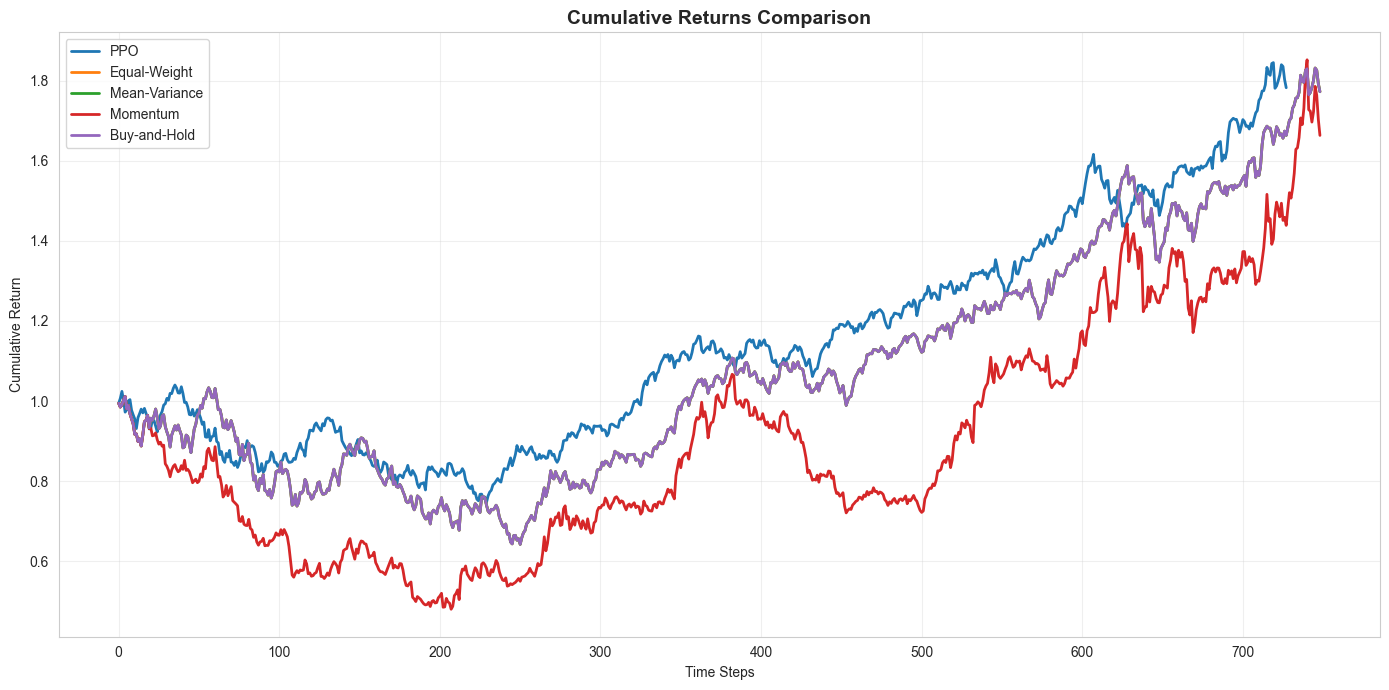

In [17]:
# Plot cumulative returns
returns_dict = {name: data['returns'] for name, data in all_results.items()}
plot_cumulative_returns(returns_dict, figsize=(14, 7))
plt.show()

### 6.2 Portfolio Values

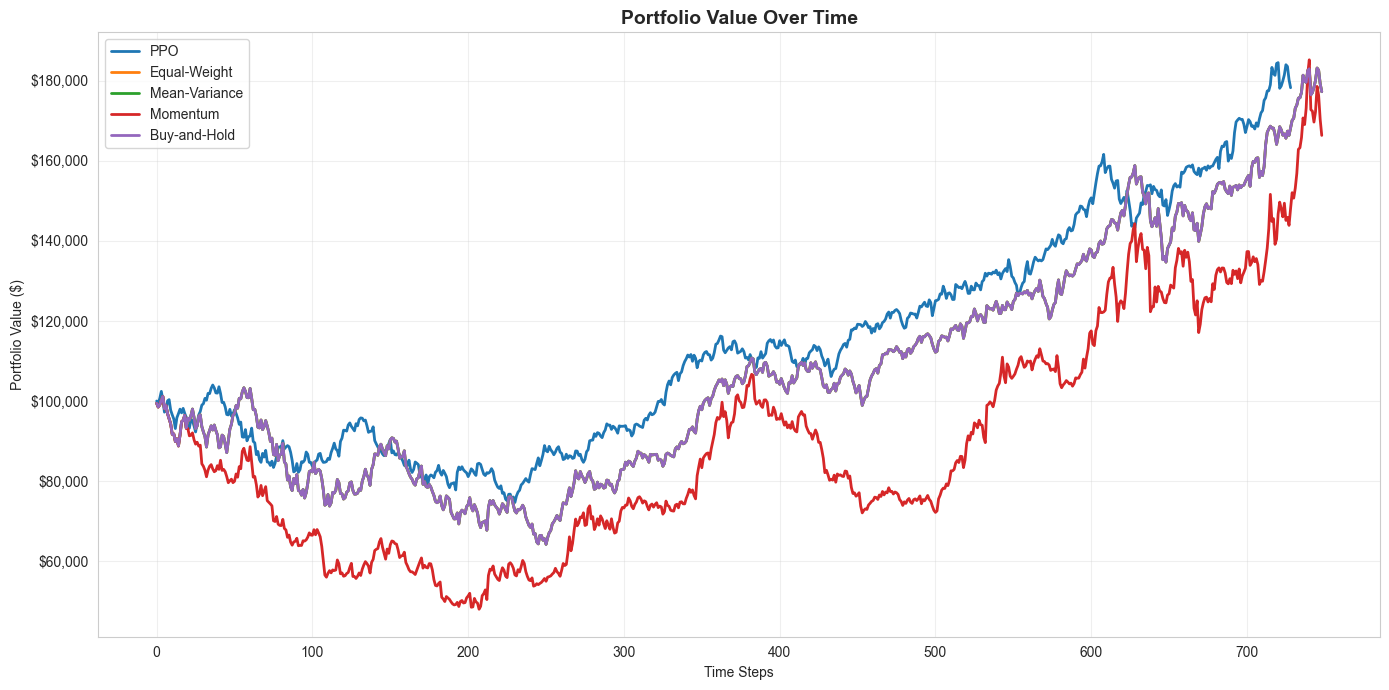

In [18]:
# Plot portfolio values
values_dict = {name: data['values'] for name, data in all_results.items()}
plot_portfolio_values(values_dict, figsize=(14, 7))
plt.show()

### 6.3 Return Distribution

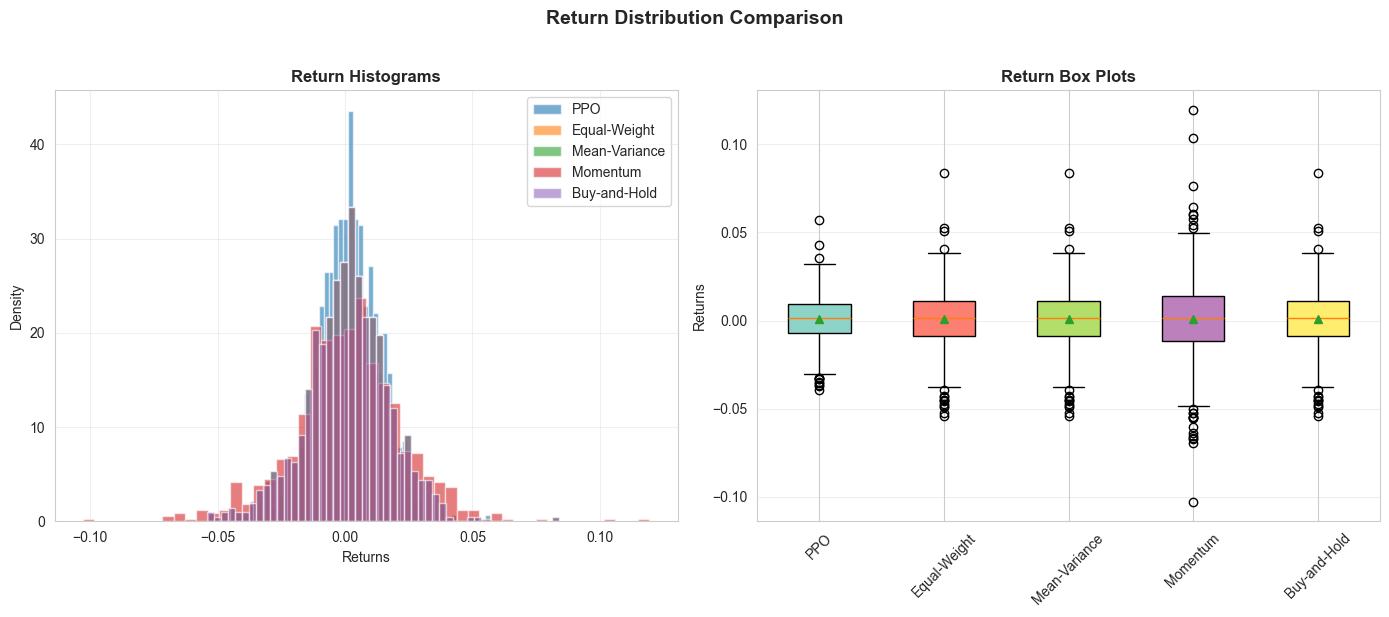

In [19]:
# Plot return distributions
plot_return_distribution(returns_dict, figsize=(14, 6))
plt.show()

### 6.4 Performance Metrics Comparison

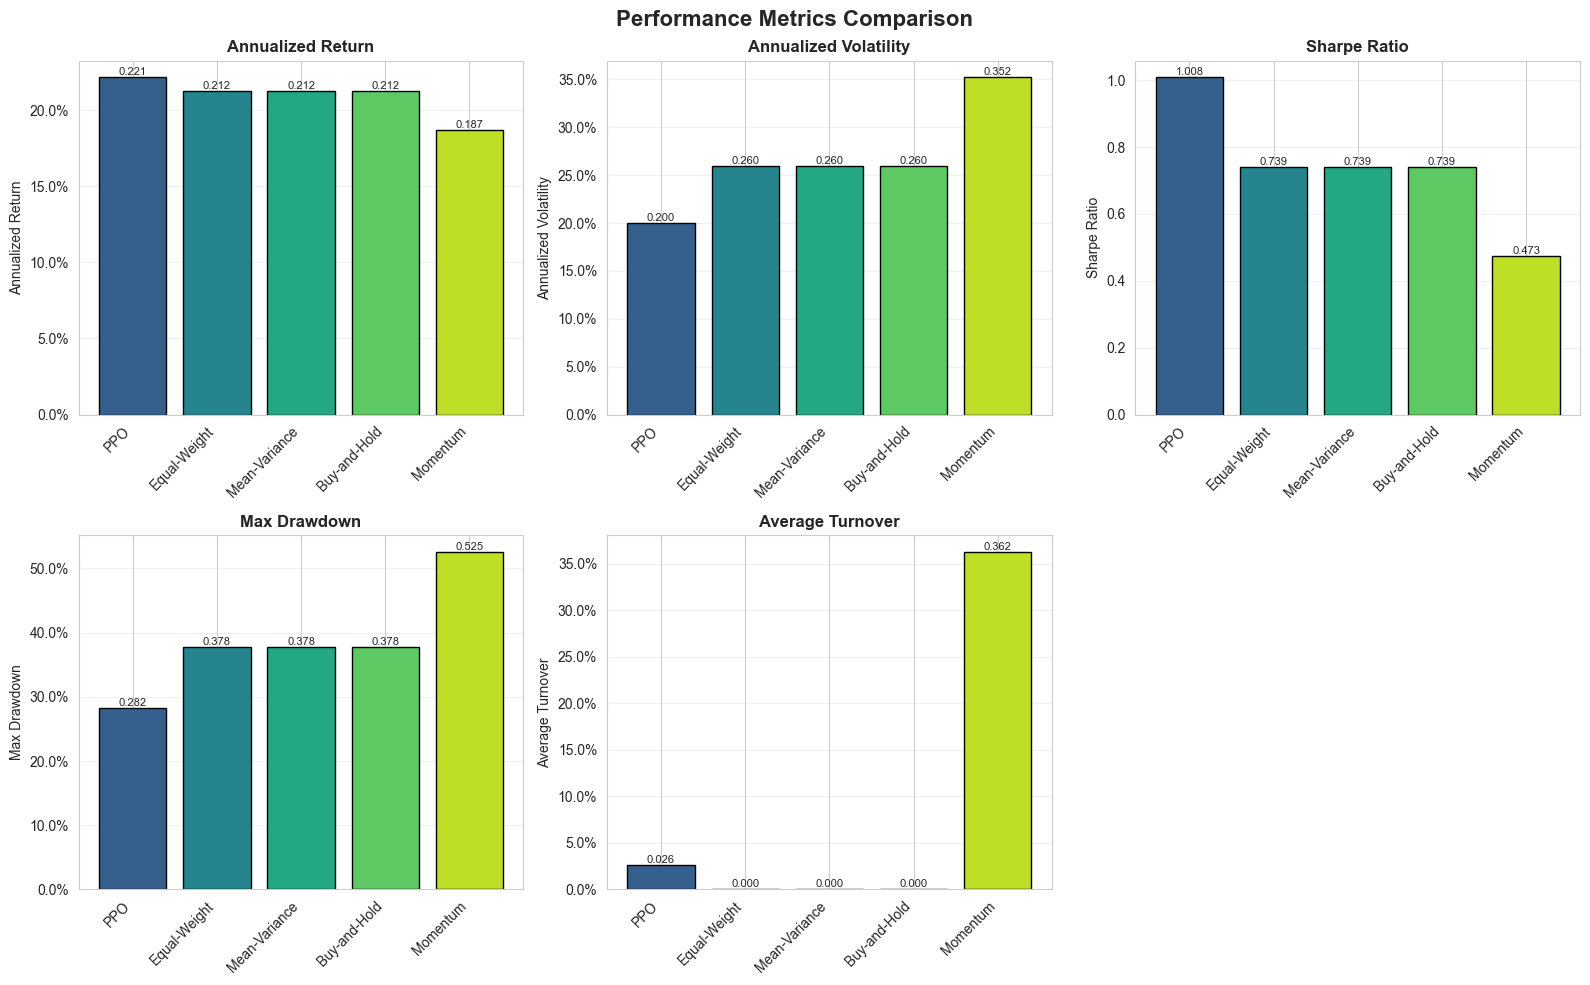

In [20]:
# Plot metrics comparison
plot_metrics_comparison(metrics_df, figsize=(16, 10))
plt.show()

### 6.5 Drawdown Analysis

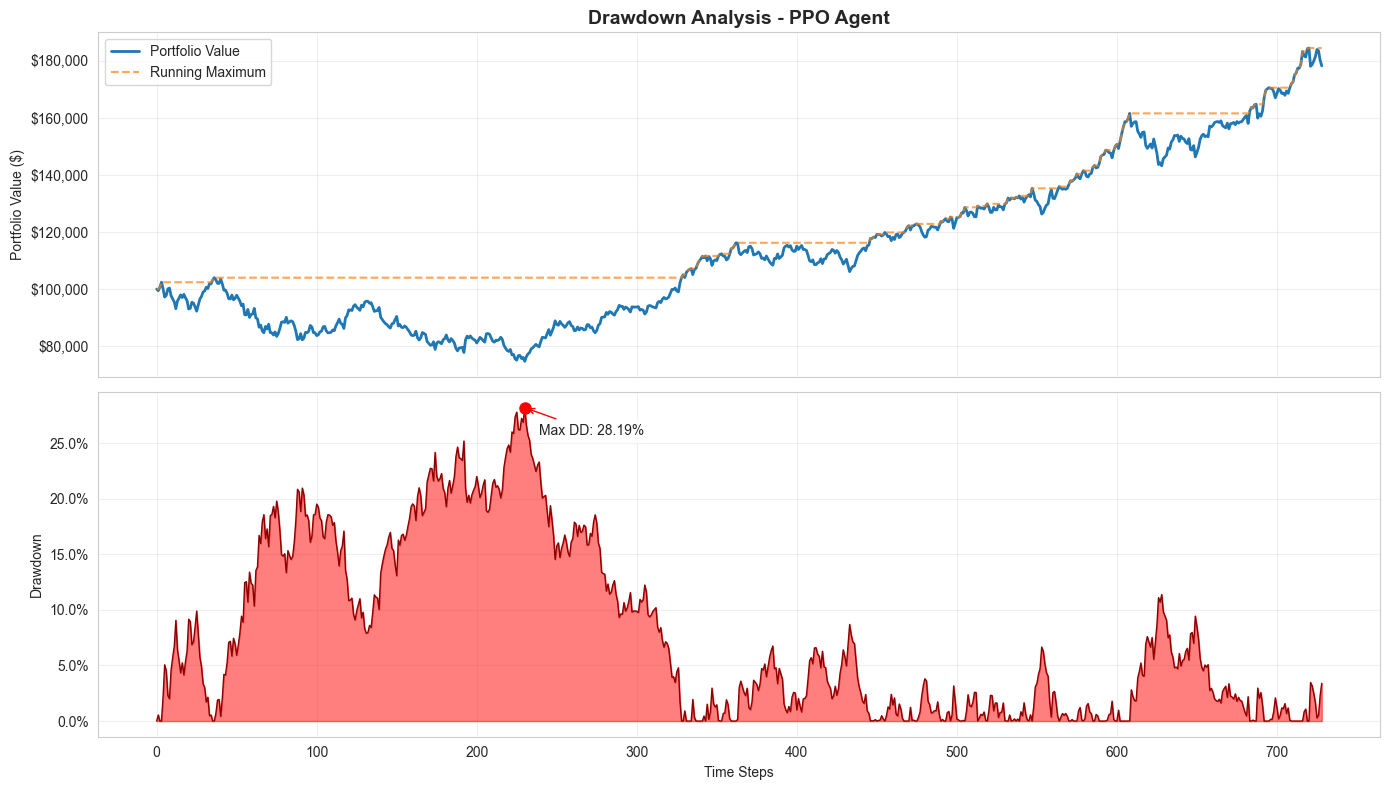

In [21]:
# Plot drawdown for PPO agent
plot_drawdown(ppo_results['values'], title="Drawdown Analysis - PPO Agent", figsize=(14, 8))
plt.show()

### 6.6 Portfolio Allocation Over Time

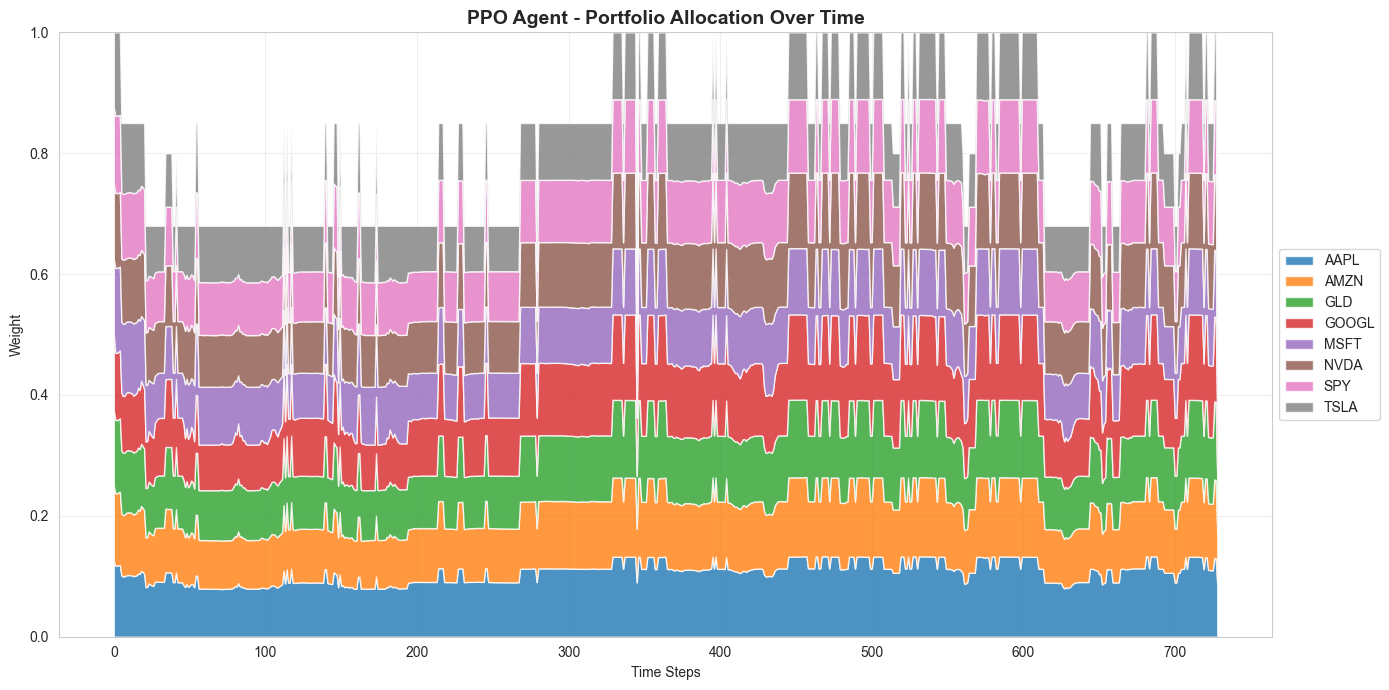

In [22]:
# Plot PPO agent's portfolio allocation
plot_weights_stacked(
    ppo_results['weights'],
    test_data['prices'].columns.tolist(),
    title="PPO Agent - Portfolio Allocation Over Time",
    figsize=(14, 7)
)
plt.show()

### 6.7 Turnover Analysis

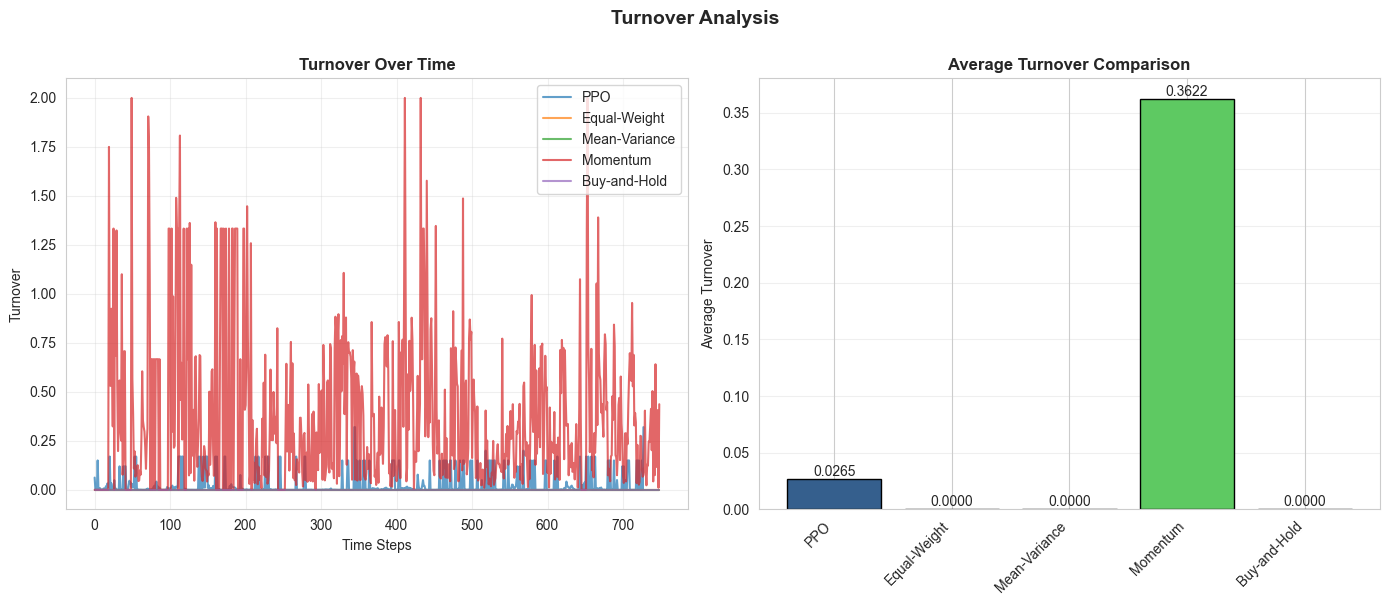

In [23]:
# Plot turnover analysis
turnover_dict = {name: data['turnover'] for name, data in all_results.items() if 'turnover' in data}
plot_turnover_analysis(turnover_dict, figsize=(14, 6))
plt.show()

## 7. Conclusions

In [24]:
# Summary statistics
print("\n" + "="*80)
print("SUMMARY AND CONCLUSIONS")
print("="*80)

print("\n1. Best Performing Strategy (by Sharpe Ratio):")
best_sharpe = metrics_df['Sharpe Ratio'].idxmax()
print(f"   Strategy: {best_sharpe}")
print(f"   Sharpe Ratio: {metrics_df.loc[best_sharpe, 'Sharpe Ratio']:.4f}")
print(f"   Annualized Return: {metrics_df.loc[best_sharpe, 'Annualized Return']:.2%}")
print(f"   Max Drawdown: {metrics_df.loc[best_sharpe, 'Max Drawdown']:.2%}")

print("\n2. Highest Return Strategy:")
best_return = metrics_df['Annualized Return'].idxmax()
print(f"   Strategy: {best_return}")
print(f"   Annualized Return: {metrics_df.loc[best_return, 'Annualized Return']:.2%}")
print(f"   Volatility: {metrics_df.loc[best_return, 'Annualized Volatility']:.2%}")

print("\n3. Lowest Risk Strategy (by Max Drawdown):")
lowest_dd = metrics_df['Max Drawdown'].idxmin()
print(f"   Strategy: {lowest_dd}")
print(f"   Max Drawdown: {metrics_df.loc[lowest_dd, 'Max Drawdown']:.2%}")
print(f"   Annualized Return: {metrics_df.loc[lowest_dd, 'Annualized Return']:.2%}")

print("\n4. PPO Agent Performance:")
if 'PPO' in metrics_df.index:
    ppo_metrics = metrics_df.loc['PPO']
    print(f"   Sharpe Ratio: {ppo_metrics['Sharpe Ratio']:.4f}")
    print(f"   Annualized Return: {ppo_metrics['Annualized Return']:.2%}")
    print(f"   Max Drawdown: {ppo_metrics['Max Drawdown']:.2%}")
    print(f"   Average Turnover: {ppo_metrics['Average Turnover']:.4f}")
    
    # Rank among all strategies
    sharpe_rank = (metrics_df['Sharpe Ratio'] > ppo_metrics['Sharpe Ratio']).sum() + 1
    print(f"   Sharpe Ratio Rank: {sharpe_rank} out of {len(metrics_df)}")

print("\n5. Key Observations:")
print("   - DRL agents learn adaptive trading policies from data")
print("   - Transaction costs significantly impact strategy performance")
print("   - Risk-adjusted metrics (Sharpe ratio) more meaningful than raw returns")
print("   - Portfolio diversification helps manage risk")

print("\n" + "="*80)
print("✓ Analysis Complete!")
print("="*80)


SUMMARY AND CONCLUSIONS

1. Best Performing Strategy (by Sharpe Ratio):
   Strategy: PPO
   Sharpe Ratio: 1.0080
   Annualized Return: 22.14%
   Max Drawdown: 28.19%

2. Highest Return Strategy:
   Strategy: PPO
   Annualized Return: 22.14%
   Volatility: 19.98%

3. Lowest Risk Strategy (by Max Drawdown):
   Strategy: PPO
   Max Drawdown: 28.19%
   Annualized Return: 22.14%

4. PPO Agent Performance:
   Sharpe Ratio: 1.0080
   Annualized Return: 22.14%
   Max Drawdown: 28.19%
   Average Turnover: 0.0265
   Sharpe Ratio Rank: 1 out of 5

5. Key Observations:
   - DRL agents learn adaptive trading policies from data
   - Transaction costs significantly impact strategy performance
   - Risk-adjusted metrics (Sharpe ratio) more meaningful than raw returns
   - Portfolio diversification helps manage risk

✓ Analysis Complete!


## Additional Experiments

Try these experiments to further explore the framework:

1. **Different Assets**: Change `ASSETS` list to include different stocks or ETFs
2. **Transaction Costs**: Vary `TRANSACTION_COST` to see impact on strategies
3. **Training Duration**: Increase `TRAIN_TIMESTEPS` for better convergence
4. **Network Architecture**: Modify `net_arch` in agent creation
5. **Reward Functions**: Try different `reward_type` values
6. **DDPG Agent**: Train and evaluate DDPG alongside PPO
7. **Market Regimes**: Analyze performance in bull vs bear markets
8. **Hyperparameter Tuning**: Optimize learning rates, batch sizes, etc.

---

**Disclaimer**: This is an academic research project for educational purposes only. Not financial advice. Do not use for real trading without proper validation.